# COVID-19 in Mexico



## Define the problem
COVID-19 is taking a big toll on the Mexican population. Currently having the 6th place worldwide. I decided to dive in and understand better the current situation in there.

The main question is: 
* Which factor has the biggest impact on predicting death once infected with COVID-19?

Other questions to tackle are:
* Is there a correlation between cases and death with days of the week?
* Does the probability of death is increased by the number of days between first symptoms and hospitalization?

* % de pruebas por entidad federativa   
* to a 100 inhabitants


* que factor tiene mayor impacto en COVID

* day of the week with more cases
* day of the week with more deaths

* Does the probability of death is increased by the number of days between first symptoms and hospitalization?

In [1]:
__author__ = "Erika Garces"
__email__ = "epgarces3@gmail.com"

In [2]:
# impory libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import geopandas as gpd
import datetime as dt
from datetime import date

from sklearn import preprocessing
from sklearn.metrics import  jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier



from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE

import itertools
from tabulate import tabulate
from IPython.display import HTML

from fbprophet import Prophet
from fbprophet.plot import plot_plotly

sns.set()
%matplotlib inline

/Users/erika/Documents/COVID/myenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


## About datasets

COVID-19 data was taken from Ministry of Health MX:  https://www.gob.mx/salud/documentos/datos-abiertos-152127

## Load the Data 

In [3]:
# Function to print all the files in a folder 
def file_folder (path):
    filepaths = [path + f for f in listdir(path)]
    print (filepaths)

In [4]:
path = "Data/"
covid_general = file_folder(path)

['Data/.DS_Store', 'Data/Mexico-2020.csv', 'Data/mexstates.dbf', 'Data/Catalogos_0412.xlsx', 'Data/mexstates.shp', 'Data/Poblacion_01.xlsx', 'Data/mexstates.shx', 'Data/mexstates.sbx', 'Data/.keep', 'Data/Poblacion_age.xlsx', 'Data/200721COVID19MEXICO.csv', 'Data/mexstates.prj', 'Data/mexstates.sbn', 'Data/mexstates.shp.xml', 'Data/Descriptores_0419.xlsx']


In [5]:
# Loading shape file
geo_states = gpd.read_file(path + "mexstates.shp")

In [6]:
# Loading covid-19 file 
df_genera_mx = pd.read_csv(path +"200721COVID19MEXICO.csv", encoding='latin-1')
df_general = df_genera_mx

In [7]:
df_descriptors = pd.read_excel(open(path + 'Descriptores_0419.xlsx', 'rb')) 
df_states = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo de ENTIDADES') 
df_sector = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo SECTOR') 
df_paciente = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo TIPO_PACIENTE') 
df_gender = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo SEXO') 

## Pre-processing data

In [8]:
# checking the size of the file 
df_general.shape 

(845272, 35)

In [9]:
df_general['SEXO']= df_general['SEXO'].replace([1, 2], [1, 0])

In [10]:
df_general['TIPO_PACIENTE'] = df_general['TIPO_PACIENTE'].map(df_paciente.set_index('CLAVE')['DESCRIPCIÓN'])

In [11]:
# It replace values for several columns in a dataframe.
def replace_values(df, columns, 
                   old_values, new_values):
    for col in columns:
        try:
            df[col]= df[col].replace(to_replace=old_values, value=new_values)
        except:
            print(col)
    return df 

In [12]:
df_general = df_general.drop(['ENTIDAD_NAC', 'ENTIDAD_RES', 'NACIONALIDAD', 
                              'PAIS_NACIONALIDAD', 'HABLA_LENGUA_INDIG', 'MIGRANTE'], axis=1)

In [13]:
df_general['FECHA_DEF'] = df_general['FECHA_DEF'].replace('9999-99-99', 0)

In [14]:
df_general['DEF'] = df_general.FECHA_DEF.apply(lambda x: 1 if x!=0 else 0)

In [15]:
#the columns were formatted to datetime.
df_general['FECHA_INGRESO'] = pd.to_datetime(df_general['FECHA_INGRESO'].str.strip(), format='%Y/%m/%d')
df_general['FECHA_SINTOMAS'] = pd.to_datetime(df_general['FECHA_SINTOMAS'].str.strip(), format='%Y/%m/%d')
df_general['FECHA_DEF'] = pd.to_datetime(df_general['FECHA_DEF'].str.strip(), format='%Y/%m/%d', errors='ignore')

In [16]:
def cal_time_days(df, column_a, column_b, new_name):
    df[new_name] = df[column_a] -  df[column_b]
    df[new_name] = df[new_name].dt.days.astype("Int32")
    df[new_name] = df[new_name].fillna(0)
    return df

In [17]:
cal_time_days(df_general,'FECHA_DEF', 'FECHA_SINTOMAS', 'DIAS_SINT_DEF')
cal_time_days(df_general,'FECHA_DEF', 'FECHA_INGRESO', 'DIAS_ING_DEF')
cal_time_days(df_general,'FECHA_INGRESO', 'FECHA_SINTOMAS', 'DIAS_SINT_ING')

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,PAIS_ORIGEN,UCI,DEF,DIAS_SINT_DEF,DIAS_ING_DEF,DIAS_SINT_ING
0,2020-07-21,10a31d,2,3,2,1,5,AMBULATORIO,2020-04-28,2020-04-24,...,2,2,1,1,99,97,0,0,0,4
1,2020-07-21,0d2fbe,2,3,25,0,6,AMBULATORIO,2020-05-25,2020-05-18,...,2,1,1,1,99,97,0,0,0,7
2,2020-07-21,116171,2,4,15,0,60,AMBULATORIO,2020-04-15,2020-04-05,...,2,2,99,1,99,97,0,0,0,10
3,2020-07-21,06d45b,2,4,15,0,121,HOSPITALIZADO,2020-04-23,2020-04-22,...,2,2,99,1,99,2,1,7,6,1
4,2020-07-21,05cbd0,2,4,31,1,101,AMBULATORIO,2020-05-04,2020-04-30,...,2,2,99,1,99,97,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845267,2020-07-21,09d62a,2,12,9,1,9,AMBULATORIO,2020-07-20,2020-07-17,...,2,2,1,3,99,97,0,0,0,3
845268,2020-07-21,15da6e,2,12,11,0,20,AMBULATORIO,2020-07-20,2020-07-20,...,2,2,1,3,99,97,0,0,0,0
845269,2020-07-21,1a8200,2,12,8,1,19,AMBULATORIO,2020-07-19,2020-07-11,...,2,2,2,3,99,97,0,0,0,8
845270,2020-07-21,052e2b,1,12,21,1,53,AMBULATORIO,2020-07-20,2020-07-12,...,2,2,2,3,99,97,0,0,0,8


In [18]:
df_general['FECHA_INGRESO_SEMANAL'] = df_general['FECHA_INGRESO'].dt.dayofweek
df_general['WEEKEND'] = df_general['FECHA_INGRESO_SEMANAL'].apply(lambda x: 1 if (x>4) else 0)

In [19]:
#Selecting the columns that have a format of SI and NO.
df_descriptors['FORMATO O FUENTE'] = df_descriptors['FORMATO O FUENTE'].str.strip()
df_si_no_answer = df_descriptors[df_descriptors['FORMATO O FUENTE']== 'CATÁLOGO: SI_ NO']
column_list_binary = list(df_si_no_answer['NOMBRE DE VARIABLE'].values)
column_list_binary.append('RESULTADO')
column_list_binary.append('OTRO_CASO')
column_list_binary.append('OTRA_COM')

In [20]:
#The values for the columns with SI NO format are replace with 1 and 0.
df_general =replace_values(df_general, column_list_binary, [97, 98, 99], [2,2,2])
df_general =replace_values(df_general, column_list_binary, [1,2], [1,0])


HABLA_LENGUA_INDIG
OTRAS_COM
MIGRANTE
HABLA_LENGUA_INDIG
OTRAS_COM
MIGRANTE


In [21]:
df_positive = df_general[ df_general['RESULTADO'] == 1]
df_positive = df_positive.drop(['RESULTADO'], axis=1)

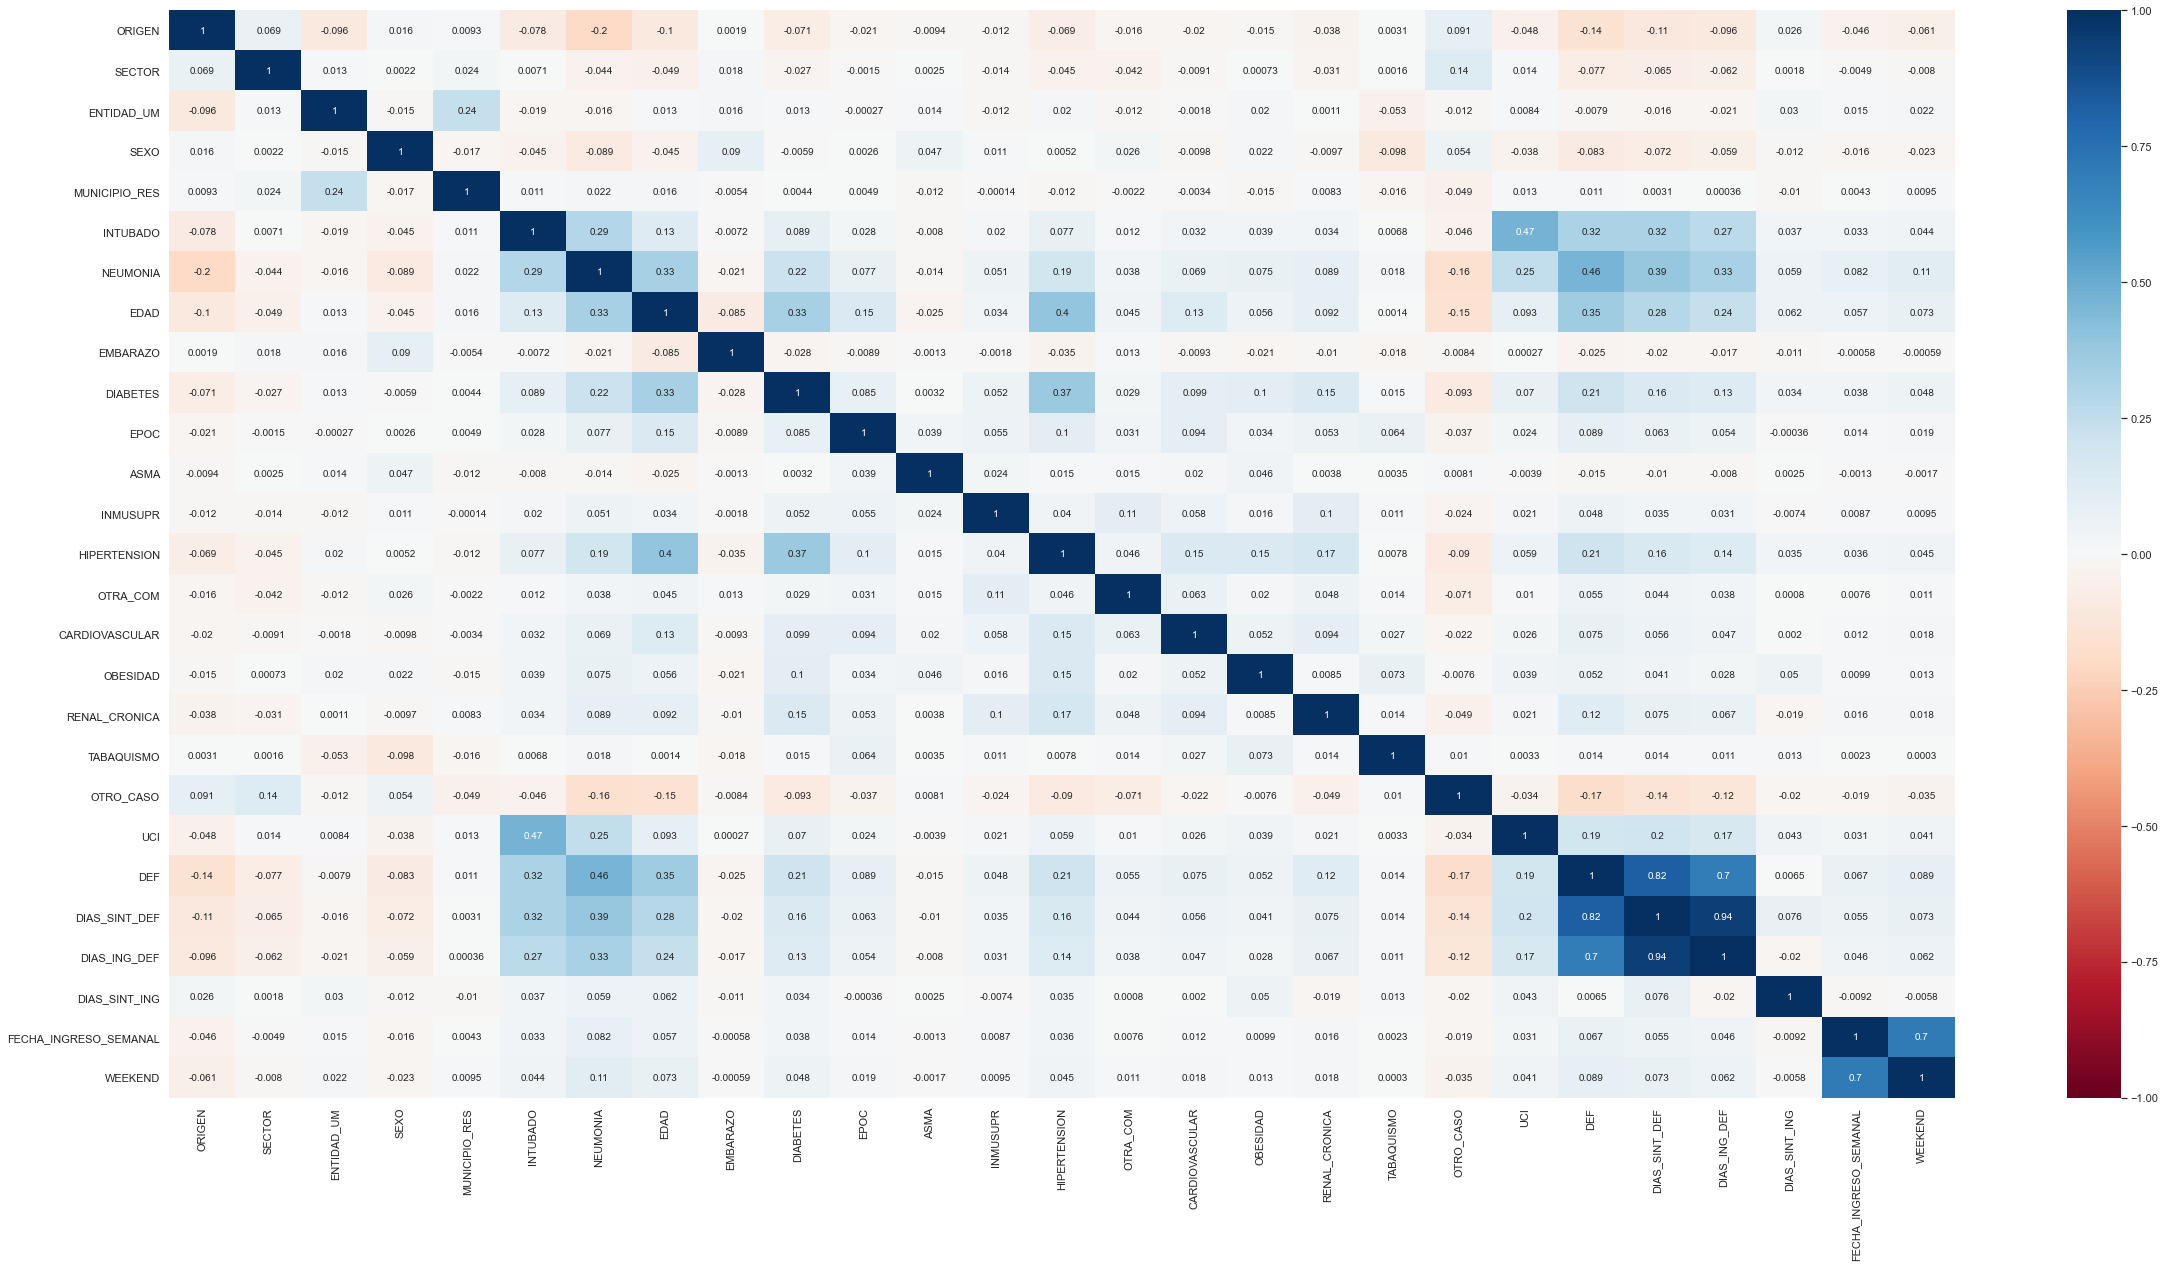

In [22]:
# Blue shows a positive correlation and red a negative. 
correlation = df_positive.corr()
plt.figure(figsize=(40, 20))
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu")

## Defining baseline model
* Which factor has the biggest impact on predicting death once infected with COVID-19?



### Feature selection
Lets defind feature sets, X:

In [23]:
df_positive.shape

(356255, 34)

In [24]:
df_positive.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'MUNICIPIO_RES', 'TIPO_PACIENTE', 'FECHA_INGRESO',
       'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA', 'EDAD',
       'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION',
       'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'PAIS_ORIGEN', 'UCI', 'DEF', 'DIAS_SINT_DEF',
       'DIAS_ING_DEF', 'DIAS_SINT_ING', 'FECHA_INGRESO_SEMANAL', 'WEEKEND'],
      dtype='object')

## One Hot Encoding

In [25]:
Feature = df_positive[['SEXO',
                      'INTUBADO', 'NEUMONIA', 'EDAD',
                      'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION',
                      'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
                      'UCI', 'DIAS_SINT_ING','WEEKEND']]
Feature = pd.concat([Feature,pd.get_dummies(df_general['TIPO_PACIENTE'])], axis=1)
Feature.head()

,SEXO,INTUBADO,NEUMONIA,EDAD,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,UCI,DIAS_SINT_ING,WEEKEND,AMBULATORIO,HOSPITALIZADO
0,1.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,1,0
1,0.0,0.0,0.0,57.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,7,0.0,1,0
2,0.0,0.0,1.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0.0,1,0
3,0.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0,1
4,1.0,0.0,0.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,1,0


In [26]:
X = Feature

In [27]:
y = df_positive['DEF']

In [28]:
#X = preprocessing.StandardScaler().fit(X).transform(X)
#X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

In [29]:
#X_test = X_test.reset_index()

In [30]:
#tsne = TSNE()
#X_embedded = tsne.fit_transform(X_test)

In [31]:
#len(X_embedded)

In [32]:
#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
#print ('Train set:', X_train.shape,  y_train.shape)
#print ('Test set:', X_test.shape,  y_test.shape)

In [33]:
#palette = sns.color_palette("bright", 10)
#sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)  

### Normalize Data
Data Standardization give data zero mean and unit variance.

In [34]:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

NameError: name 'X_train' is not defined

## Model for Classification



## LogisticRegression

In [ ]:
LR_model = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
LR_model

In [ ]:
LR_model.score(X_test, y_test)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
LR_yhat = LR_model.predict(X_test) # Predict class labels for samples in X.
cnf_matrix = confusion_matrix(y_test, LR_yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, LR_yhat))


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Alive(0)','Die (1)'],normalize= False,  title='Confusion matrix')

In [ ]:
LR_yhat = LR_model.predict(X_test) # Predict class labels for samples in X.
LR_yhat_prob = LR_model.predict_proba(X_test) # Probability estimates.
logistic_jaccard = jaccard_similarity_score(y_test, LR_yhat)
logistic_f1 = f1_score(y_test, LR_yhat, average='weighted') 
logistic_log_loss = log_loss(y_test, LR_yhat_prob)
print ("LR Jaccard index: %.2f" % logistic_jaccard)
print ("LR F1-score: %.2f" % logistic_f1)
print ("LR LogLoss: %.2f" % logistic_log_loss)

## Support Vector Machine 

In [ ]:
clf = SGDClassifier(max_iter=1000, tol=1e-3)

In [ ]:
clf.fit(X_train, y_train) 

In [ ]:
clf.score(X_test, y_test)

In [ ]:
SVM_yhat = clf.predict(X_test)

In [ ]:
cnf_matrix = confusion_matrix(y_test, SVM_yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, SVM_yhat))


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Alive(0)','Die (1)'],normalize= False,  title='SVM Confusion matrix')

In [ ]:
SVM_jaccard = jaccard_similarity_score(y_test,SVM_yhat)
SVM_f1 = f1_score(y_test,SVM_yhat, average='weighted')
print ("SVM Jaccard index: %.2f" %  SVM_jaccard)
print ("SVM F1-score: %.2f" % SVM_f1)

In [ ]:
table = [ ["SVM", "%.3f" % SVM_jaccard, "%.3f" % SVM_f1,'NA'],
         ["Logistic Regression", "%.3f" %  logistic_jaccard, "%.3f" % logistic_f1, "%.3f" % logistic_log_loss]]


HTML(tabulate(table, headers= ['Algorithm', 'Jaccard', 'F1-score','LogLoss'], tablefmt='html'))

## Time series

In [35]:
df_general_ts = df_general[ df_general['RESULTADO'] == 1]

In [36]:
df_time_pos = df_general.FECHA_SINTOMAS.value_counts().to_frame()
df_time_pos = df_time_pos.reset_index()
df_time_pos.rename(columns={df_time_pos.columns[0]: 'ds', 'FECHA_SINTOMAS': 'y' }, inplace = True)

In [37]:
m = Prophet()
m.fit(df_time_pos)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [39]:
future = m.make_future_dataframe(periods=90)
future.tail()

,ds
288,2020-10-15
289,2020-10-16
290,2020-10-17
291,2020-10-18
292,2020-10-19


In [40]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
288,2020-10-15,17320.082616,14606.988226,20235.546174
289,2020-10-16,17911.787536,15330.107909,20755.573392
290,2020-10-17,17286.563928,14735.448105,20108.516320
291,2020-10-18,17191.595906,14453.815736,19986.646009
292,2020-10-19,18359.707031,15428.505228,21111.411574


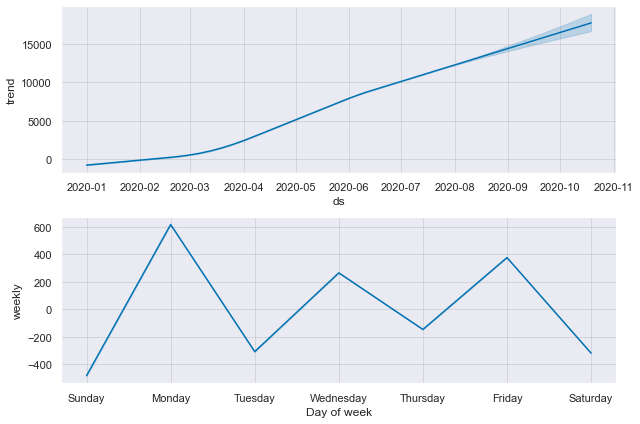

In [41]:
fig2 = m.plot_components(forecast)

In [42]:
df_general_death = df_general[ df_general['DEF'] == 1]

In [43]:
df_general_death

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,OTRO_CASO,RESULTADO,PAIS_ORIGEN,UCI,DEF,DIAS_SINT_DEF,DIAS_ING_DEF,DIAS_SINT_ING,FECHA_INGRESO_SEMANAL,WEEKEND
3,2020-07-21,06d45b,2,4,15,0,121,HOSPITALIZADO,2020-04-23,2020-04-22,...,0,1,99,0,1,7,6,1,3,0
8,2020-07-21,1a48a6,2,4,15,0,25,AMBULATORIO,2020-04-28,2020-04-24,...,0,1,99,0,1,5,1,4,1,0
18,2020-07-21,07d20e,2,4,25,0,1,AMBULATORIO,2020-04-28,2020-04-26,...,0,1,99,0,1,4,2,2,1,0
21,2020-07-21,00582d,2,3,15,0,20,HOSPITALIZADO,2020-06-29,2020-06-22,...,0,1,99,0,1,9,2,7,0,0
24,2020-07-21,086194,2,3,15,1,90,AMBULATORIO,2020-06-13,2020-06-08,...,0,1,99,0,1,8,3,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844813,2020-07-21,181d4d,1,4,26,1,30,HOSPITALIZADO,2020-07-12,2020-06-30,...,0,3,99,0,1,12,0,12,6,1
844838,2020-07-21,0a9074,2,99,21,1,207,HOSPITALIZADO,2020-07-05,2020-07-05,...,0,3,99,0,1,7,7,0,6,1
844869,2020-07-21,067f58,1,6,29,0,33,HOSPITALIZADO,2020-07-10,2020-07-03,...,0,3,99,0,1,11,4,7,4,0
845213,2020-07-21,021b6a,1,4,9,0,10,HOSPITALIZADO,2020-07-09,2020-07-02,...,0,3,99,0,1,12,5,7,3,0


In [44]:
df_ts_death = df_general_death.FECHA_DEF.value_counts().to_frame()
df_ts_death = df_ts_death.reset_index()
df_ts_death.rename(columns={df_ts_death.columns[0]: 'ds', 'FECHA_DEF': 'y' }, inplace = True)

In [45]:
df_ts_death

,ds,y
0,2020-06-16,783
1,2020-06-08,751
2,2020-06-12,733
3,2020-06-10,730
4,2020-06-17,729
...,...,...
143,2020-02-09,1
144,2020-01-31,1
145,2020-03-12,1
146,2020-02-21,1


In [46]:
prophet_death = Prophet()
prophet_death.fit(df_ts_death)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [51]:
future_death = prophet_death.make_future_dataframe(periods=90)
future_death.tail()

,ds
233,2020-10-15
234,2020-10-16
235,2020-10-17
236,2020-10-18
237,2020-10-19


In [55]:
forecast_death = prophet_death.predict(future_death)
forecast_death[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
233,2020-10-15,828.289360,649.348088,996.258344
234,2020-10-16,820.115796,655.403297,990.847693
235,2020-10-17,819.614674,647.649216,987.494807
236,2020-10-18,822.941641,660.163303,992.387008
237,2020-10-19,838.090462,679.730281,995.208676


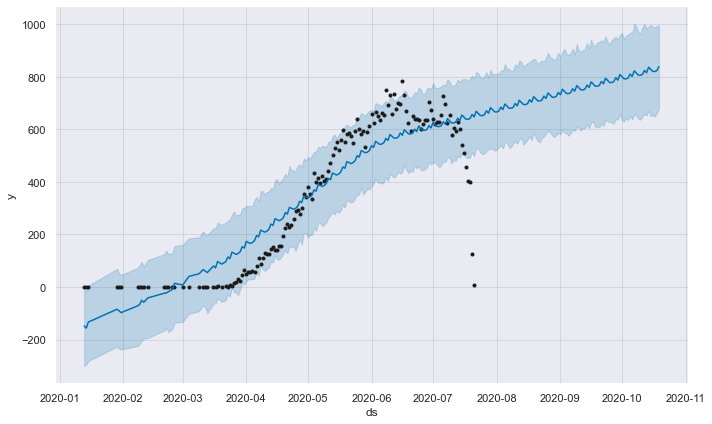

In [56]:
fig1 = prophet_death.plot(forecast_death)

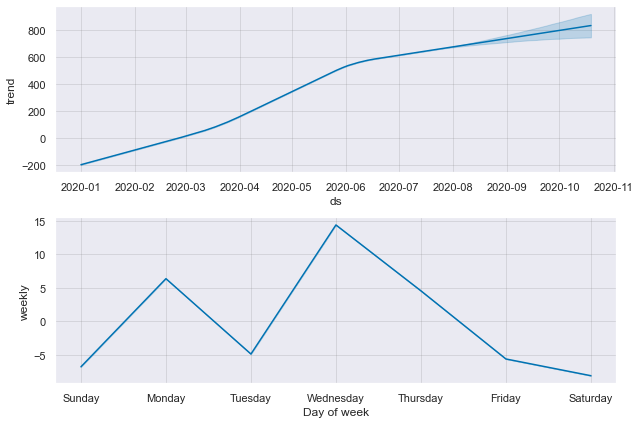

In [50]:
fig2 = prophet_death.plot_components(forecast)